# ResNet50 ImageNet Training Pipeline

Complete training pipeline for ResNet50 on ImageNet-1K dataset.

## Features:
- Automatic dataset download from Hugging Face
- Training on M4 Mac (MPS) or AWS (CUDA)
- Mixed precision training (CUDA only)
- Checkpoint saving and resuming
- Training visualization
- Modular code structure

## 1. Setup and Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

# Import our modules
from model import create_resnet50, get_model_stats
from data_loader_small import get_small_dataloaders
from data_loader_full import get_full_dataloaders
from train import Trainer
from data_normalisation import denormalize_image

print("✓ All modules imported successfully!")
print(f"PyTorch version: {torch.__version__}")

/Users/prateekgarg/Documents/ERAV4/Session_9/Assignment/Image_net_training_model/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ All modules imported successfully!
PyTorch version: 2.8.0


## 2. Configuration

Edit these settings based on your needs:

In [ ]:
# ========================================
# CONFIGURATION - PHASE 2: Scale to 500k Samples
# ========================================

config = {
    # ====================================================================
    # PHASE 2: Resume Training with 500k Samples (6.25x more data!)
    # ====================================================================

    # Dataset settings
    'use_small_dataset': True,  # Still using subset loader
    'data_dir': './imagenet_data',
    'num_samples': 500000,  # INCREASED from 80,000 to 500,000
    'auto_download': True,  # Will download additional 420k images
    
    # Resume from Phase 1 (your existing 75 epochs on 80k)
    'resume_from_checkpoint': True,  # ✅ Load weights from Phase 1
    'checkpoint_dir': 'checkpoints',
    'load_optimizer_state': False,  # ✅ Fresh optimizer state for new data scale
    
    # Training settings
    'batch_size': 128,
    'num_workers': 4,
    'num_epochs': 50,  # Train 50 MORE epochs (total: 75+50=125)
    
    # Learning Rate Strategy (IMPORTANT CHOICE):
    # OPTION A: Re-run LR Finder (RECOMMENDED)
    'find_lr': True,  # Will find optimal LR for 500k dataset
    'lr_finder_init': 1e-8,
    'lr_finder_end': 10,
    'lr_finder_iterations': 100,
    
    # OPTION B: If you want to skip LR Finder and use fixed LR, uncomment:
    # 'find_lr': False,
    'initial_lr': 0.01,  # Starting LR (will be overridden if find_lr=True)
    'max_lr': 0.1,  # Maximum LR for OneCycleLR
    
    # Optimizer settings
    'momentum': 0.9,
    'weight_decay': 1e-4,
    
    # OneCycleLR settings
    'use_onecycle': True,
    'pct_start': 0.3,
    'div_factor': 25.0,
    'final_div_factor': 10000.0,
    
    # Regularization - upgraded for more data
    'advanced_augmentation': True,
    'augmentation_strength': 'medium',  # Upgraded from 'light'
    'label_smoothing': 0.1,  # Increased from 0.05
    'max_grad_norm': 1.0,
    
    # Phase tracking
    'training_phase': 'Phase 2: 500k samples',
}

print("="*70)
print("CONFIGURATION: PHASE 2 - Scale to 500k Samples")
print("="*70)
for key, value in config.items():
    print(f"  {key}: {value}")

print("\n" + "="*70)
print("PHASE 2 INFORMATION")
print("="*70)
print(f"Previous training (Phase 1):")
print(f"  ├─ Samples: 80,000")
print(f"  ├─ Epochs: 75")
print(f"  ├─ Best Val Accuracy: ~9.6%")
print(f"  └─ Status: ✅ COMPLETE (checkpoint saved)")
print(f"\nPhase 2 (Current):")
print(f"  ├─ Samples: 500,000 (6.25x more!)")
print(f"  ├─ New epochs to train: 50")
print(f"  ├─ Total epochs after Phase 2: 125")
print(f"  └─ Expected Val Accuracy: 45-55%")
print(f"\nKey Changes:")
print(f"  ✅ Download 420,000 additional images (~3-4 hours)")
print(f"  ✅ Re-run LR Finder for optimal learning rate")
print(f"  ✅ Fresh optimizer state (no old momentum)")
print(f"  ✅ Stronger augmentation ('medium' instead of 'light')")
print(f"  ✅ Higher label smoothing (0.1)")
print(f"\nWhat Will Happen:")
print(f"  1. Load model weights from Phase 1 checkpoint")
print(f"  2. Download additional 420k images (if needed)")
print(f"  3. Run LR Finder on new 500k dataset")
print(f"  4. Train for 50 more epochs")
print(f"  5. Expected accuracy jump: 9.6% → 45-55%")
print(f"\nTraining Time Estimates:")
print(f"  • Download: 3-4 hours (one-time)")
print(f"  • M4 Mac: 50 epochs × 1.5 hours = ~75 hours")
print(f"  • AWS g4dn.xlarge: 50 epochs × 45 min = ~37 hours (~$20)")
print("="*70)

## 3. Device Setup

Automatically detect available device (MPS, CUDA, or CPU):

In [3]:
# Setup device
if torch.backends.mps.is_available():
    device = torch.device("mps")
    device_name = "Apple Silicon MPS"
elif torch.cuda.is_available():
    device = torch.device("cuda")
    device_name = f"CUDA: {torch.cuda.get_device_name(0)}"
else:
    device = torch.device("cpu")
    device_name = "CPU"

print(f"\n{'='*60}")
print(f"Using device: {device_name}")
print(f"{'='*60}\n")


Using device: Apple Silicon MPS



## 4. Load Dataset

This will automatically download the dataset if not found:

In [ ]:
# Load data
if config['use_small_dataset']:
    print("Loading small dataset (subset)...")
    train_loader, val_loader, num_classes, class_names = get_small_dataloaders(
        data_dir=config['data_dir'],
        batch_size=config['batch_size'],
        num_workers=config['num_workers'],
        num_samples=config['num_samples'],
        auto_download=config['auto_download'],
        advanced_augmentation=config['advanced_augmentation'],
        augmentation_strength=config.get('augmentation_strength', 'light'),
        pin_memory=True
    )
else:
    print("Loading FULL ImageNet dataset...")
    print("This will download ~150GB if not already present...")
    train_loader, val_loader, num_classes, class_names = get_full_dataloaders(
        data_dir=config['data_dir'],
        batch_size=config['batch_size'],
        num_workers=config['num_workers'],
        advanced_augmentation=config['advanced_augmentation'],
        augmentation_strength=config.get('augmentation_strength', 'medium'),
        pin_memory=True
    )

print(f"\n✓ Data loaded successfully!")
print(f"  Number of classes: {num_classes}")
print(f"  Train samples: {len(train_loader.dataset):,}")
print(f"  Val samples: {len(val_loader.dataset):,}")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Augmentation strength: {config.get('augmentation_strength', 'medium')}")

## 5. Visualize Sample Images

Let's look at some training samples:

Sample training images:


/Users/prateekgarg/Documents/ERAV4/Session_9/Assignment/Image_net_training_model/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


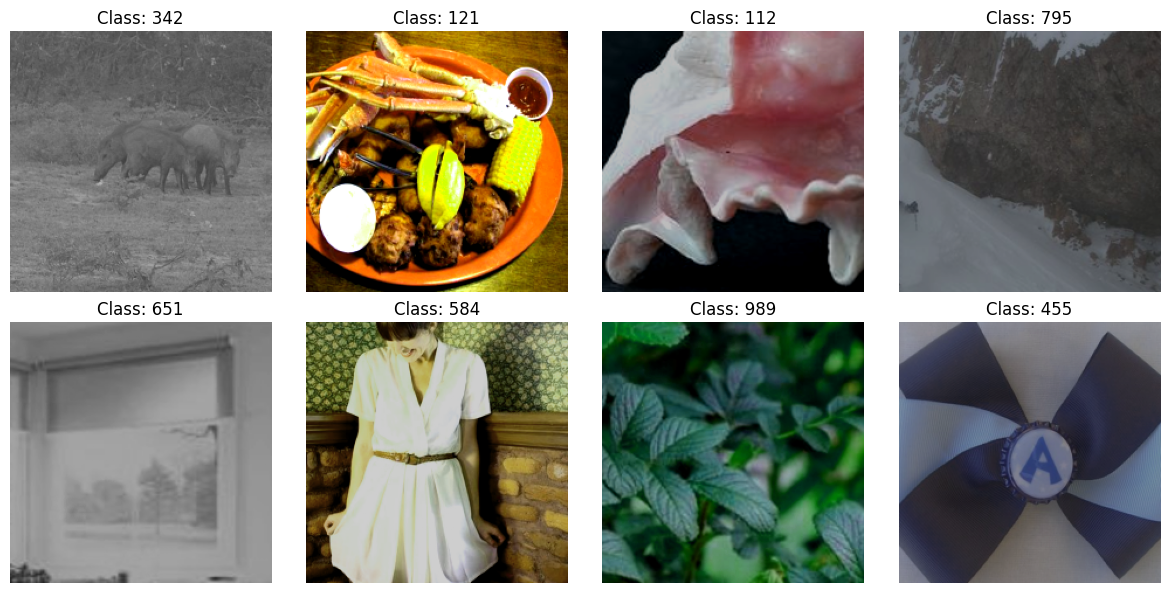

In [5]:
# Visualize sample images
def show_batch(loader, num_images=8):
    """Display a batch of images"""
    dataiter = iter(loader)
    images, labels = next(dataiter)
    
    # Denormalize for visualization
    images_denorm = denormalize_image(images)
    
    # Plot
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.flatten()
    
    for idx in range(min(num_images, len(images))):
        img = images_denorm[idx].permute(1, 2, 0).cpu().numpy()
        axes[idx].imshow(img)
        axes[idx].set_title(f"Class: {labels[idx].item()}")
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

print("Sample training images:")
show_batch(train_loader)

## 6. Create Model

Create ResNet50 model and display statistics:

In [6]:
# Create model
model = create_resnet50(num_classes=num_classes, zero_init_residual=True)
model = model.to(device)

# Get model statistics
stats = get_model_stats(model)

print(f"\n{'='*60}")
print("Model: ResNet50")
print(f"{'='*60}")
print(f"Total parameters: {stats['total_parameters']:,}")
print(f"Trainable parameters: {stats['trainable_parameters']:,}")
print(f"Model size: {stats['model_size_mb']:.2f} MB")
print(f"Number of classes: {num_classes}")
print(f"{'='*60}\n")


Model: ResNet50
Total parameters: 25,557,032
Trainable parameters: 25,557,032
Model size: 97.49 MB
Number of classes: 1000



## 7. Setup Training

Configure optimizer, loss, and scheduler:

In [ ]:
# def param_groups_weight_decay(model, weight_decay=1e-4):
#     decay, no_decay = [], []
#     for m in model.modules():
#         if isinstance(m, (torch.nn.BatchNorm2d, torch.nn.GroupNorm, torch.nn.LayerNorm)):
#             for p in m.parameters(recurse=False):
#                 if p.requires_grad: no_decay.append(p)
#         else:
#             for name, p in m.named_parameters(recurse=False):
#                 if not p.requires_grad: 
#                     continue
#                 if name.endswith("bias"):
#                     no_decay.append(p)
#                 else:
#                     decay.append(p)
#     return [
#         {'params': decay, 'weight_decay': weight_decay},
#         {'params': no_decay, 'weight_decay': 0.0},
#     ]



In [ ]:
# def set_bn_eval(model):
#     for m in model.modules():
#         if isinstance(m, torch.nn.BatchNorm2d):
#             m.eval()       # uses running stats
#             m.requires_grad_(True)  # keep γ/β learnable

# # 2) (Optional) freeze BN on MPS small-batch
# if torch.backends.mps.is_available():
#     set_bn_eval(model)

# # 3) Run LR finder over, say, 200 steps on a subset loader



In [ ]:
# # 1) Build optimizer with separated WD
# opt = torch.optim.SGD(
#     param_groups_weight_decay(model, weight_decay=1e-4),
#     lr=1e-3, momentum=0.9, nesterov=True
# )

# # 2) (Optional) freeze BN on MPS small-batch
# if torch.backends.mps.is_available():
#     set_bn_eval(model)

# trainer = Trainer(model, device, checkpoint_dir=config['checkpoint_dir'])

# # 3) Run LR finder over, say, 200 steps on a subset loader
# lr_search = trainer.lr_find(
#     model, train_loader, nn.CrossEntropyLoss(label_smoothing=0.1), opt,
#     start_lr=1e-6, end_lr=1.0, num_iter=200
# )
# print(f"LR Finder suggested LR ≈ {lr_search['suggested']:.3e}")
# # Use ~1/3 of suggested as your initial LR for warmup
# warmup_base_lr = lr_search['suggested'] / 3

2025-10-15 17:58:51,329 - INFO - Trainer initialized on device: mps
2025-10-15 17:58:51,329 - INFO - Mixed precision (AMP) enabled: False


LR Finder suggested LR ≈ 1.415e-06


In [ ]:
# import math

# start_epoch = 0
# best_acc = 0.0

# def build_warmup_cosine(optimizer, warmup_epochs, total_epochs, base_lr, min_lr=1e-6):
#     def lr_lambda(epoch):
#         if epoch < warmup_epochs:
#             return (epoch + 1) / warmup_epochs
#         # cosine from 1 → min_lr/base_lr
#         t = (epoch - warmup_epochs) / max(1, total_epochs - warmup_epochs)
#         return 0.5 * (1 + math.cos(math.pi * t)) * (1 - min_lr/base_lr) + min_lr/base_lr
#     return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# # After LR finder:
# #base_lr = warmup_base_lr if on_mac_subset else 0.1 * (effective_batch/256)



# # lr_search = trainer.lr_find(
# #     model, train_loader, nn.CrossEntropyLoss(label_smoothing=0.1), opt,
# #     start_lr=1e-6, end_lr=1.0, num_iter=200
# # )
# # print(f"LR Finder suggested LR ≈ {lr_search['suggested']:.3e}")
# # # Use ~1/3 of suggested as your initial LR for warmup
# # warmup_base_lr = lr_search['suggested'] / 3

# base_lr = warmup_base_lr
# optimizer = torch.optim.SGD(
#     param_groups_weight_decay(model, weight_decay=1e-4),
#     lr=base_lr, momentum=0.9, nesterov=True
# )
# scheduler = build_warmup_cosine(
#     optimizer, warmup_epochs=5, total_epochs=config['num_epochs'],
#     base_lr=base_lr, min_lr=1e-6
# )
# criterion = nn.CrossEntropyLoss(label_smoothing=0.1)



LR Finder suggested LR ≈ 3.740e-06


In [ ]:
# This cell intentionally moved - checkpoint loading now happens after optimizer/scheduler creation
# See cell after optimizer setup for checkpoint resume logic

In [ ]:
# Loss function with label smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=config['label_smoothing'])

# Optimizer
optimizer = optim.SGD(
    model.parameters(),
    lr=config['initial_lr'],
    momentum=config['momentum'],
    weight_decay=config['weight_decay']
)

# Learning rate scheduler - OneCycleLR for better convergence
if config['use_onecycle']:
    # Calculate total steps for OneCycleLR
    steps_per_epoch = len(train_loader)
    total_steps = config['num_epochs'] * steps_per_epoch
    
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=config['max_lr'],
        total_steps=total_steps,
        epochs=config['num_epochs'],
        steps_per_epoch=steps_per_epoch,
        pct_start=config['pct_start'],
        div_factor=config['div_factor'],
        final_div_factor=config['final_div_factor'],
        anneal_strategy='cos',
        three_phase=False
    )
    scheduler_name = "OneCycleLR"
else:
    # Fallback to CosineAnnealingWarmRestarts
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=10, T_mult=2, eta_min=1e-6
    )
    scheduler_name = "CosineAnnealingWarmRestarts"

# Initialize trainer with gradient clipping
trainer = Trainer(
    model, 
    device, 
    checkpoint_dir=config['checkpoint_dir'],
    max_grad_norm=config.get('max_grad_norm', None)
)

print("✓ Training setup complete!")
print(f"  Optimizer: SGD (lr={config['initial_lr']}, momentum={config['momentum']})")
print(f"  Scheduler: {scheduler_name}")
if config['use_onecycle']:
    print(f"    - max_lr: {config['max_lr']}")
    print(f"    - warmup: {config['pct_start']*100:.0f}% of training")
    print(f"    - total_steps: {total_steps}")
print(f"  Loss: CrossEntropyLoss (label_smoothing={config['label_smoothing']})")
print(f"  Gradient clipping: {'Enabled (max_norm=' + str(config.get('max_grad_norm')) + ')' if config.get('max_grad_norm') else 'Disabled'}")

# ============================================================================
# CHECKPOINT RESUME - Load Phase 1 weights and continue training
# ============================================================================
start_epoch = 0
best_acc = 0.0

if config['resume_from_checkpoint']:
    print("\n" + "="*70)
    print("🔄 RESUMING FROM CHECKPOINT (Phase 2)")
    print("="*70)

    # Check if we should load optimizer state
    load_opt_state = config.get('load_optimizer_state', True)

    checkpoint, start_epoch, best_acc = trainer.load_checkpoint(
        model, optimizer, scheduler,
        load_optimizer_state=load_opt_state
    )

    if checkpoint:
        start_epoch += 1  # Start from next epoch
        print(f"\n✅ Successfully resumed from epoch {start_epoch-1}")
        print(f"   📊 Best accuracy so far: {best_acc:.2f}%")
        print(f"   📈 Will continue training from epoch {start_epoch}")

        if not load_opt_state:
            print(f"   ⚠️  Optimizer state NOT loaded (fresh LR schedule)")
            print(f"   🔍 LR Finder will determine optimal LR for new dataset")
        else:
            print(f"   ✅ Optimizer state loaded (continuing from previous training)")

        # Show dataset change info
        if 'dataset_info' in checkpoint:
            old_samples = checkpoint.get('dataset_info', {}).get('num_samples', 'unknown')
            new_samples = config['num_samples']
            print(f"   📦 Dataset scaled: {old_samples} → {new_samples:,} samples")

        print("="*70 + "\n")
    else:
        print("\n❌ No checkpoint found, starting from scratch")
        print("="*70 + "\n")
else:
    print("\n" + "="*70)
    print("Starting training from scratch (no checkpoint resume)")
    print("="*70 + "\n")

## 8. Resume from Checkpoint (Optional)

Resume training from a previous checkpoint:

In [ ]:
# Checkpoint resume is now handled in the previous cell (after optimizer/scheduler creation)
# This ensures optimizer and scheduler exist before trying to load their states

# The variables start_epoch and best_acc are set in the previous cell

## 9. Train the Model

Main training loop:

In [12]:
print(f"\n{'='*60}")
print(f"Starting Training")
print(f"{'='*60}")
print(f"Start epoch: {start_epoch}")
print(f"End epoch: {config['num_epochs']}")
print(f"Device: {device_name}")
print(f"Mixed Precision: {trainer.use_amp}")
print(f"{'='*60}\n")

# Train!
model, best_acc, history = trainer.train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=config['num_epochs'],
    start_epoch=start_epoch,
    best_acc=best_acc
)

print(f"\n{'='*60}")
print("Training Complete!")
print(f"{'='*60}")
print(f"Best validation accuracy: {best_acc:.2f}%")
print(f"Final top-5 accuracy: {max(history['val_top5_acc']):.2f}%")
print(f"{'='*60}\n")

2025-10-15 22:36:01,973 - INFO - Starting training from epoch 0 to 90
2025-10-15 22:36:01,974 - INFO - 
Epoch 0/89, LR: 4.00e-10



Starting Training
Start epoch: 0
End epoch: 90
Device: Apple Silicon MPS
Mixed Precision: False



Epoch 0 [Train]:  55%|█████▍    | 343/625 [08:18<06:49,  1.45s/it, loss=6.94, acc=0.118] 

: 

## 10. Visualize Training Results

Plot training curves:

In [ ]:
def plot_training_history(history):
    """Plot training history"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss plot
    axes[0, 0].plot(history['train_loss'], label='Train Loss', linewidth=2)
    axes[0, 0].plot(history['val_loss'], label='Val Loss', linewidth=2)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training and Validation Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Top-1 Accuracy
    axes[0, 1].plot(history['train_acc'], label='Train Acc', linewidth=2, color='green')
    axes[0, 1].plot(history['val_acc'], label='Val Acc', linewidth=2, color='red')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].set_title('Top-1 Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Top-5 Accuracy
    axes[1, 0].plot(history['val_top5_acc'], label='Val Top-5', linewidth=2, color='purple')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Top-5 Accuracy (%)')
    axes[1, 0].set_title('Top-5 Accuracy')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Learning Rate
    axes[1, 1].plot(history['lr'], linewidth=2, color='orange')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Learning Rate')
    axes[1, 1].set_title('Learning Rate Schedule')
    axes[1, 1].set_yscale('log')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(Path(config['checkpoint_dir']) / 'training_history.png', dpi=150)
    plt.show()

# Plot results
plot_training_history(history)

## 11. Training Statistics

Display detailed training statistics:

In [ ]:
# Calculate statistics
total_epochs = len(history['train_loss'])
total_time_hours = sum(history['epoch_time']) / 3600
avg_epoch_time = np.mean(history['epoch_time'])
best_epoch = history['val_acc'].index(max(history['val_acc']))

print(f"\n{'='*60}")
print("Training Statistics")
print(f"{'='*60}")
print(f"Total epochs trained: {total_epochs}")
print(f"Best epoch: {best_epoch + 1}")
print(f"\nBest Metrics:")
print(f"  Top-1 Accuracy: {max(history['val_acc']):.2f}%")
print(f"  Top-5 Accuracy: {max(history['val_top5_acc']):.2f}%")
print(f"  Validation Loss: {min(history['val_loss']):.4f}")
print(f"\nFinal Metrics:")
print(f"  Train Loss: {history['train_loss'][-1]:.4f}")
print(f"  Train Accuracy: {history['train_acc'][-1]:.2f}%")
print(f"  Val Loss: {history['val_loss'][-1]:.4f}")
print(f"  Val Accuracy: {history['val_acc'][-1]:.2f}%")
print(f"\nTiming:")
print(f"  Total training time: {total_time_hours:.2f} hours")
print(f"  Average epoch time: {avg_epoch_time:.2f} seconds")
print(f"\nCheckpoints saved to: {config['checkpoint_dir']}")
print(f"{'='*60}\n")

## 12. Test Model Inference

Test the trained model on a few examples:

In [ ]:
# Test inference
model.eval()

# Get a batch from validation set
dataiter = iter(val_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# Make predictions
with torch.no_grad():
    outputs = model(images)
    probabilities = torch.nn.functional.softmax(outputs, dim=1)
    top5_prob, top5_idx = torch.topk(probabilities, 5, dim=1)

# Visualize predictions
images_denorm = denormalize_image(images)
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for idx in range(min(8, len(images))):
    img = images_denorm[idx].permute(1, 2, 0).cpu().numpy()
    axes[idx].imshow(img)
    
    # Get predictions
    true_label = labels[idx].item()
    pred_label = top5_idx[idx][0].item()
    pred_prob = top5_prob[idx][0].item()
    
    # Color: green if correct, red if wrong
    color = 'green' if pred_label == true_label else 'red'
    
    axes[idx].set_title(
        f"True: {true_label}\nPred: {pred_label} ({pred_prob*100:.1f}%)",
        color=color
    )
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig(Path(config['checkpoint_dir']) / 'predictions.png', dpi=150)
plt.show()

# Calculate accuracy on this batch
correct = (top5_idx[:, 0] == labels).sum().item()
batch_acc = 100. * correct / len(labels)
print(f"\nBatch accuracy: {batch_acc:.2f}%")

## 13. Save Final Report

Generate a summary report:

In [ ]:
import json

# Create comprehensive report
report = {
    'training_config': config,
    'device': device_name,
    'model': {
        'architecture': 'ResNet50',
        'parameters': stats['total_parameters'],
        'size_mb': stats['model_size_mb'],
    },
    'dataset': {
        'type': 'small_subset' if config['use_small_dataset'] else 'full',
        'num_classes': num_classes,
        'train_batches': len(train_loader),
        'val_batches': len(val_loader),
    },
    'results': {
        'best_top1_accuracy': max(history['val_acc']),
        'best_top5_accuracy': max(history['val_top5_acc']),
        'best_epoch': history['val_acc'].index(max(history['val_acc'])) + 1,
        'total_epochs': len(history['train_loss']),
        'final_train_loss': history['train_loss'][-1],
        'final_val_loss': history['val_loss'][-1],
        'total_training_time_hours': sum(history['epoch_time']) / 3600,
    },
    'timestamp': datetime.now().isoformat(),
}

# Save report
report_path = Path(config['checkpoint_dir']) / 'training_report.json'
with open(report_path, 'w') as f:
    json.dump(report, f, indent=2)

print(f"\n✓ Training report saved to: {report_path}")
print("\n" + "="*60)
print("All Done! 🎉")
print("="*60)
print(f"\nBest model saved at: {config['checkpoint_dir']}/best_model.pth")
print(f"Best Top-1 Accuracy: {max(history['val_acc']):.2f}%")
print(f"Best Top-5 Accuracy: {max(history['val_top5_acc']):.2f}%")

## Next Steps

### For Development (M4 Mac):
1. Start with small dataset (`use_small_dataset=True`, `num_samples=80000`)
2. Train for a few epochs to validate the pipeline
3. Check `training_history.png` for training curves
4. Experiment with hyperparameters

### For Production (AWS):
1. Transfer code and checkpoints to AWS
2. Set `use_small_dataset=False` for full ImageNet
3. Set `resume_from_checkpoint=True` to continue from M4 Mac training
4. Use multi-GPU training with larger batch sizes
5. Train to achieve 80%+ top-1 accuracy

### Model Deployment:
1. Use `best_model_weights.pth` for inference
2. Export to ONNX or TorchScript for production
3. Deploy on Hugging Face Spaces or custom API

---

**Good luck with your training! 🚀**